In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [3]:
df = df[df.columns[df.isnull().mean() < 0.8]]

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [4]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [5]:
row_sums = crosstab_result.sum(axis=1)
proportions = crosstab_result.div(row_sums, axis=0)
print(proportions)

isBestSeller                       False     True 
category                                          
3D Printers                     0.995968  0.004032
3D Printing & Scanning          0.999508  0.000492
Abrasive & Finishing Products   0.980000  0.020000
Action Cameras                  0.999411  0.000589
Adapters                        0.988189  0.011811
...                                  ...       ...
Wind Instruments                0.972000  0.028000
Window Treatments               0.979079  0.020921
Women                           0.988015  0.011985
Women's Sports & Outdoor Shoes  0.989791  0.010209
eBook Readers & Accessories     1.000000  0.000000

[296 rows x 2 columns]


In [6]:
categories_with_more_true = proportions[proportions[True] > proportions[False]].index
print(categories_with_more_true)

Index([], dtype='object', name='category')


There are no categories where being a best-seller is more prevalent.

2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [7]:
from scipy.stats import chi2_contingency
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)
chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

The null hypothesis of the Chi-square test is that the two categorical variables are independent. Given the low ( p )-value, we reject the null hypothesis. This implies that there's a significant association between category and isBestSeller in the dataset.

In [8]:
from scipy.stats.contingency import association
association(crosstab_result, method="cramer")

0.1222829439760564

The Cramér's V value of 0.122 suggests a weak association between the two variables.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

<Axes: xlabel='category'>

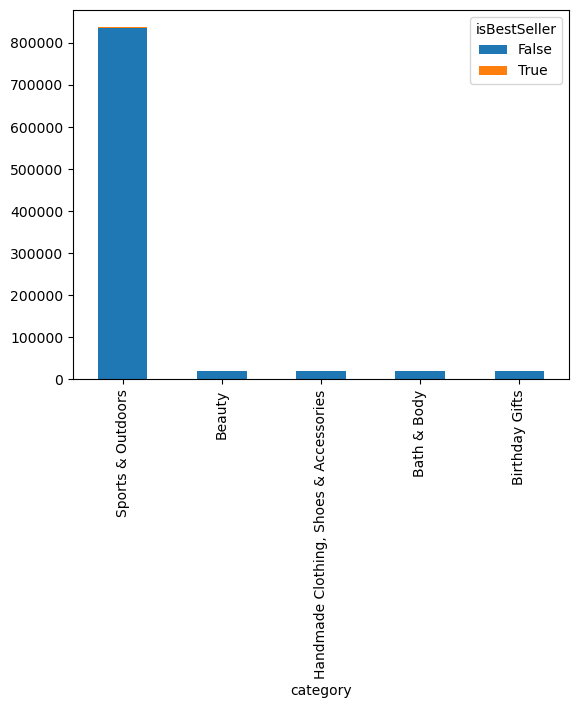

In [9]:
sorted_categories = crosstab_result.sum(axis=1).sort_values(ascending=False)
top_5_categories = sorted_categories.head(5).index
top_5_crosstab = crosstab_result.loc[top_5_categories]
top_5_crosstab.plot(kind="bar", stacked=True)

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*


In [10]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

In [11]:
tukeys_test_outliers(df["price"])

10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64

In [12]:
def remove_tukeys_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return cleaned_data

In [13]:
remove_tukeys_outliers(df["price"])

0          21.99
1          23.99
2          21.99
3          31.99
4          17.99
           ...  
2443646    22.34
2443647    97.99
2443648    52.99
2443649    79.99
2443650    53.99
Name: price, Length: 2115963, dtype: float64

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

<Axes: xlabel='category', ylabel='price'>

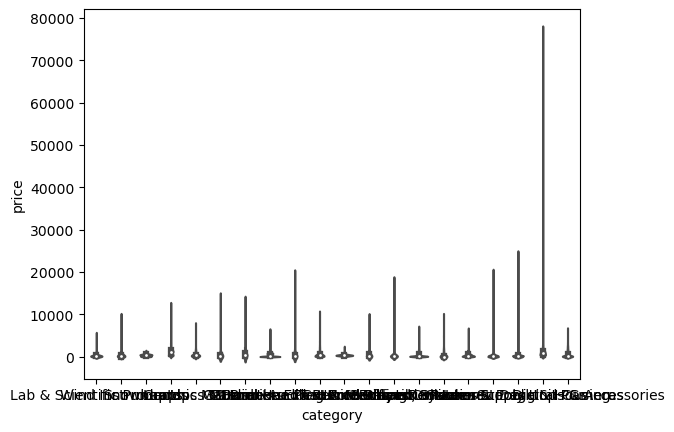

In [14]:
top_20_categories = df.groupby('category')['price'].mean().nlargest(20).index
filtered_df = df[df['category'].isin(top_20_categories)]
sns.violinplot(data=filtered_df, x='category', y='price', palette="coolwarm")

<Axes: xlabel='category', ylabel='price'>

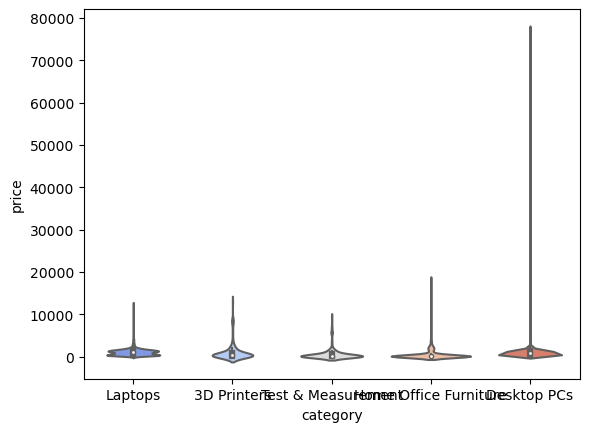

In [15]:
top_5_categories = df.groupby('category')['price'].mean().nlargest(5).index
filtered_df = df[df['category'].isin(top_5_categories)]
sns.violinplot(data=filtered_df, x='category', y='price', palette="coolwarm")

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

<Axes: xlabel='category', ylabel='price'>

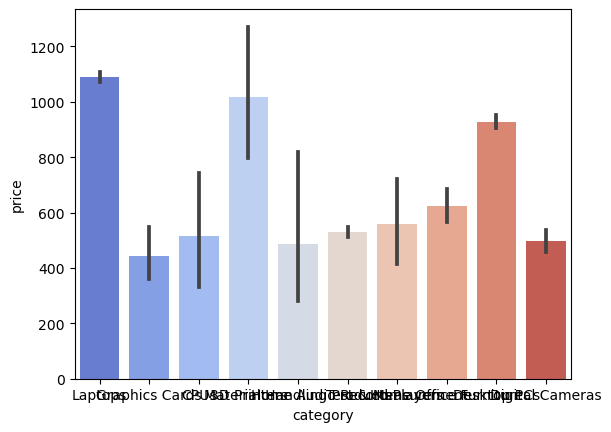

In [16]:
top_10_categories = df.groupby('category')['price'].mean().nlargest(10).index
filtered_df = df[df['category'].isin(top_10_categories)]
sns.barplot(data=filtered_df, x='category', y='price', palette="coolwarm")

<Axes: xlabel='category', ylabel='price'>

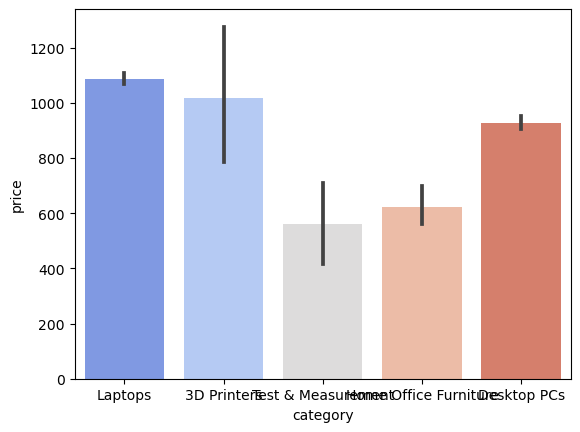

In [17]:
top_5_categories = df.groupby('category')['price'].mean().nlargest(5).index
filtered_df = df[df['category'].isin(top_5_categories)]
sns.barplot(data=filtered_df, x='category', y='price', palette="coolwarm")

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

<Axes: xlabel='category', ylabel='price'>

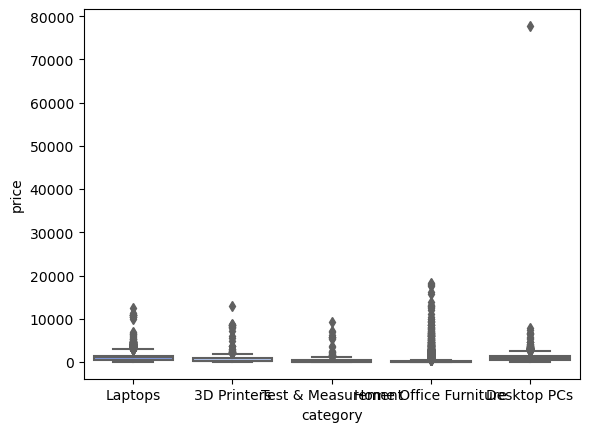

In [18]:
top_5_categories = df.groupby('category')['price'].mean().nlargest(5).index
filtered_df = df[df['category'].isin(top_5_categories)]
sns.boxplot(data=filtered_df, x='category', y='price', palette="coolwarm")

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [19]:
correlation = df['price'].corr(df['stars'])
correlation

-0.1249067326214861

There seems to be a weak negative correlation of rating and price.

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

<Axes: xlabel='price', ylabel='stars'>

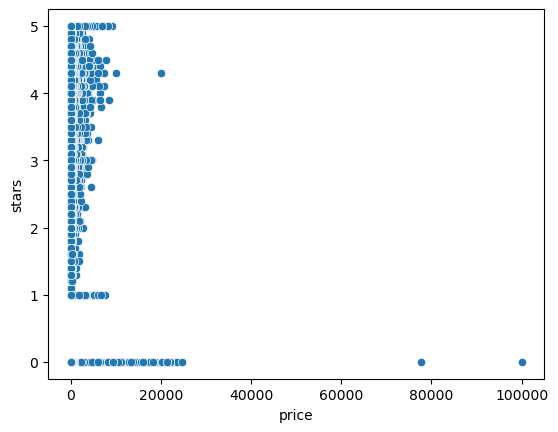

In [24]:
sns.scatterplot(data=df, x='price', y='stars')

In [22]:
potential_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20]
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

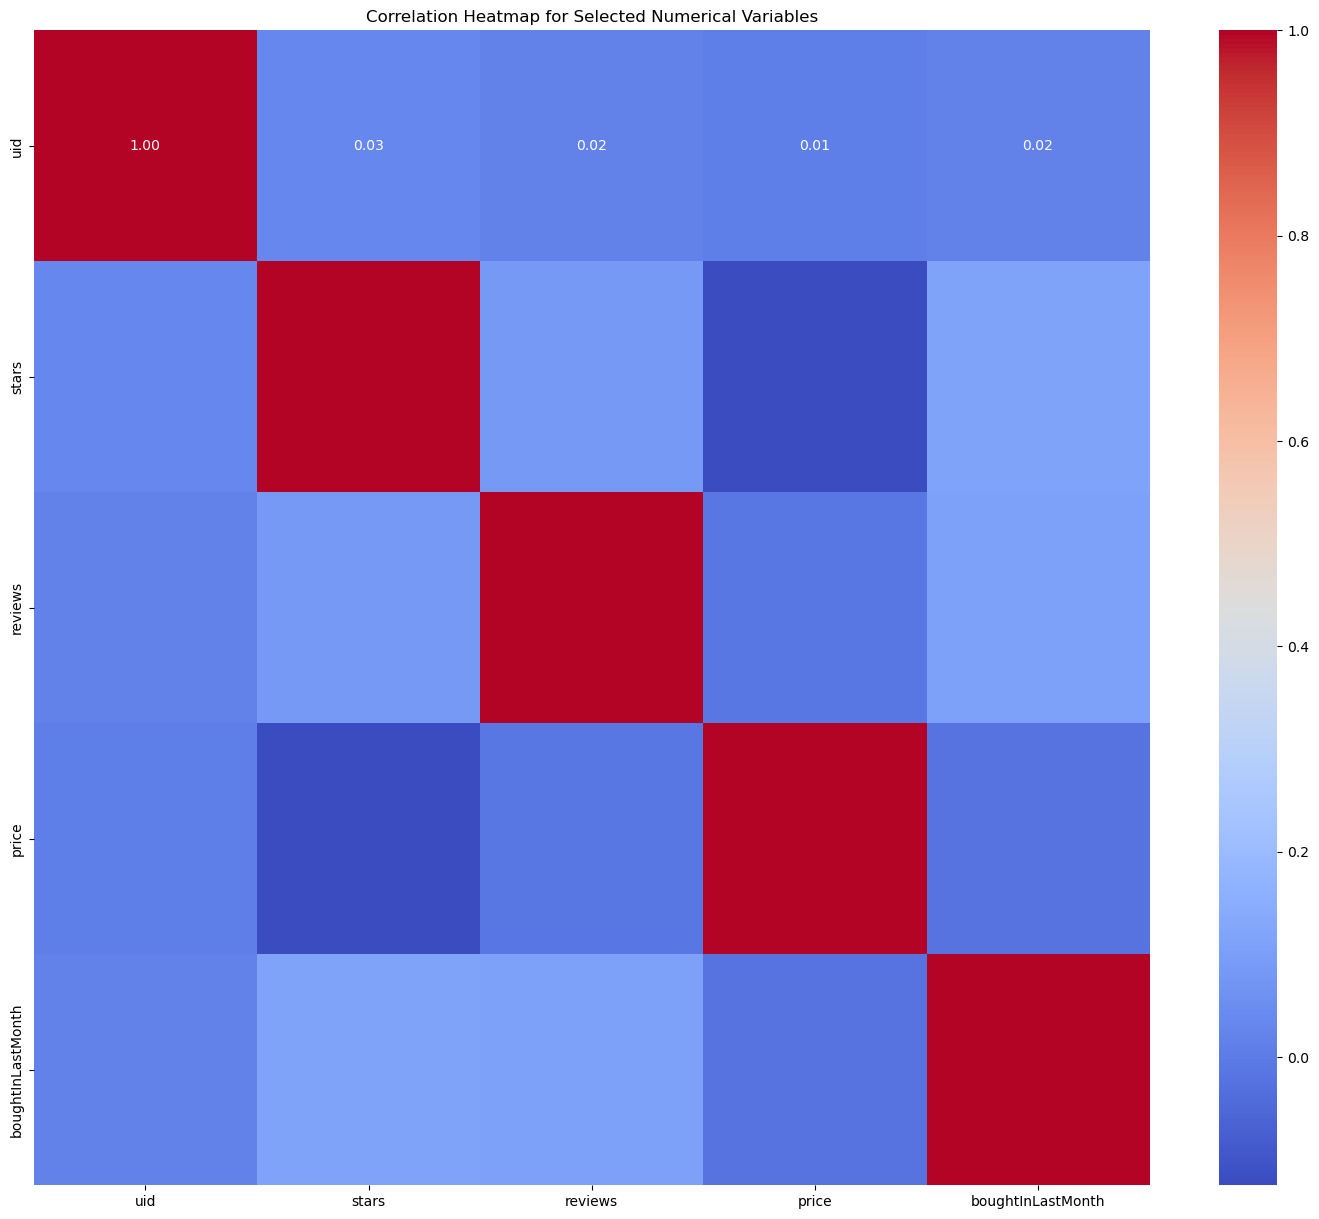

In [23]:
correlation_matrix = df_numerical.corr()
annot_values = correlation_matrix.values
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=annot_values, cmap="coolwarm", fmt="0.2f")
plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

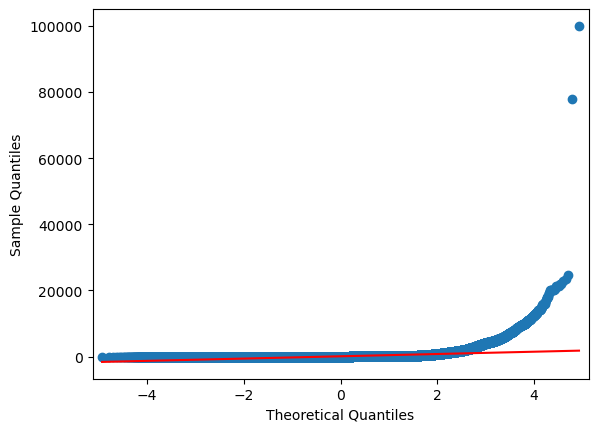

In [25]:
import statsmodels.api as sm

sm.qqplot(df['price'], line='s');